# Imports

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# from tensorboardX import SummaryWriter
# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange

# writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print('GPU available? {}'.format(torch.cuda.is_available()))

GPU available? False


# Generate dataset

In [3]:
def toy_function(N):
    
    noise_std = 0.02
    eps_train = noise_std*np.random.randn(N,)
    eps_test =  noise_std*np.random.randn(int(N*0.5),)
    
    
    x_train = np.linspace(0, 0.5, N, endpoint=True, dtype =np.float32)
    x_test =  np.linspace(-1, 1, int(N*0.5), endpoint=True, dtype =np.float32)
    
    y_train = x_train + 0.3*np.sin(2*np.pi*(x_train + eps_train)) + 0.3*np.sin(4*np.pi*(x_train + eps_train)) + eps_train
    y_test =  x_test + 0.3*np.sin(2*np.pi*(x_test + eps_test)) + 0.3*np.sin(4*np.pi*(x_test + eps_test)) + eps_test
    
    x_train = np.atleast_2d(x_train).T
    x_test = np.atleast_2d(x_test).T
    
    x_train_tensor = torch.Tensor(x_train)
    y_train_tensor = torch.Tensor(y_train)
    x_test_tensor =  torch.Tensor(x_test)
    y_test_tensor =  torch.Tensor(y_test)
    
    plt.plot(x_train, y_train, 'rs', label='train')
    plt.plot(x_test, y_test, 'k.', label='test')
    plt.legend()
    plt.show()

    return x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor

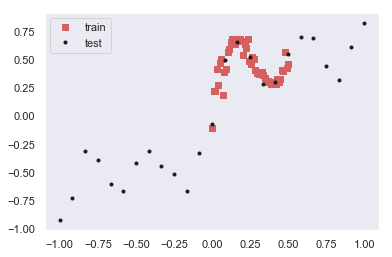

In [4]:
x_train, y_train, x_test, y_test = toy_function(50)

In [ ]:
# N = 30
# x_train = np.random.uniform(0.3, 2.5, N).astype(np.float32)
# x_test =  np.linspace(0, 3, N*4, endpoint=True, dtype =np.float32)
# eps = 0.02*np.random.randn(N,)
# y_train = 0.4*x_train + 0.8*np.sin(2*np.pi*(x_train + eps)) + 0.8*np.sin(4*np.pi*(x_train + eps)) + eps
# eps = 0.02*np.random.randn(N*4,)
# y_test = 0.2*x_test + 0.8*np.sin(2*np.pi*(x_test + eps)) + 0.8*np.sin(4*np.pi*(x_test + eps)) + eps

# x_train = np.atleast_2d(x_train).T
# x_test = np.atleast_2d(x_test).T

# plt.plot(x_train, y_train, 'rs', label='train')
# plt.plot(x_test, y_test, 'k.', label='test')
# plt.legend()
# plt.show()



# Standard MLP

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, arch):
        self.input_size = input_size
        self.output_size = output_size
        self.arch = arch
        self.num_hidden_layers = len(arch)
        
        super().__init__()

        self.layers = nn.ModuleList([nn.Linear(input_size, arch[0])])  # input layer
        self.layers.extend([nn.Linear(arch[i-1], arch[i]) for i in range(1, self.num_hidden_layers)])  # hidden layers
        self.layers.append(nn.Linear(arch[-1], output_size))  # output layers
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        for i in range(len(self.layers)-1):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)
        return x.squeeze()
    
nnet = NeuralNetwork(1, 1, [10, 10]) #.to(DEVICE)



In [ ]:
TRAIN_EPOCHS = 2000

optimizer = optim.Adam(nnet.parameters(), lr=1e-2)
criterion = nn.MSELoss()# Mean Squared Loss

nnet.train()

data = torch.tensor(x_train, dtype=torch.float32)
target = torch.tensor(y_train, dtype=torch.float32)

losses = list()
for epoch in range(TRAIN_EPOCHS):

    optimizer.zero_grad()
    outputs = nnet(data)
    loss = criterion(outputs, target)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    

plt.plot(losses)
plt.show()

In [ ]:
# for name, param in nnet.named_parameters():
#     if param.requires_grad:
#         print('{} : {}'.format(name, param.data))

In [ ]:
nnet.eval()
with torch.no_grad():
    y_pred = nnet(x_test).numpy()
    
plt.figure()
plt.plot(x_train.numpy(), y_train.numpy(), 'rs', label='Train points')
plt.plot(x_test.numpy(), y_test.numpy(), 'k.', markersize=10, label='Test points')
plt.plot(x_test.numpy(), y_pred, 'b-', label='Test predictions')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

# Gaussian Process

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared, WhiteKernel

# x_train = np.atleast_2d(x_train).T
# x_test = np.atleast_2d(x_test)

kernel =  RBF(1) + WhiteKernel(1e-1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_test, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x_train.numpy(), y_train.numpy(), 'rs', label='Train points')
plt.plot(x_test.numpy(), y_test.numpy(), 'k.', markersize=10, label='Test points')
plt.plot(x_test.numpy(), y_pred, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test.numpy(), x_test.numpy()[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()



# Bayes-by-Backprop

/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
100%|██████████| 5000/5000 [00:33<00:00, 147.55it/s]


Finished Training


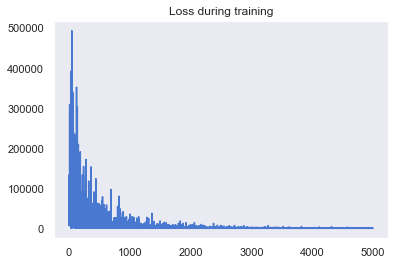

In [9]:
from BBB_SMM import MLP_BBB

prior_pi = 0.5
prior_sigma1 = 1 
prior_sigma2 = 10
net = MLP_BBB(1, 1, [5, 5], prior_pi, prior_sigma1, prior_sigma2, noise_tol=0.02)

net.to(DEVICE)
net.train()

data = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
target = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=1e-2)
epochs = 5000

loss_arr = list()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(data, target, 1)
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())

print('Finished Training')

plt.plot(loss_arr)
# plt.yscale('log')
plt.title('Loss during training')
plt.show()

/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Users/goncalves1/local/anaconda3/envs/mtl4c/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


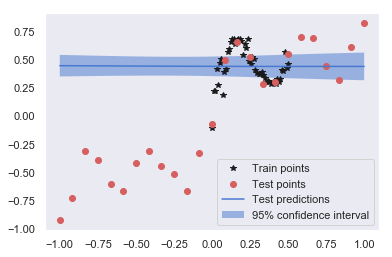

In [10]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

net.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = net(data_ts).detach().numpy().ravel()
    post_dist[:, n_post_samples] = net(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Train points')
plt.plot(x_test.numpy(), y_test.numpy(), 'ro', label='Test points')
plt.plot(x_test.numpy(), y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test.numpy(), x_test.numpy()[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()

# Bayes-by-backprop - Learning Noise Variance

In [ ]:
from BBB_v2 import MLP_BBB

nnet = MLP_BBB(1, 1, [10, 10], prior_var=1, prior_noise_var=0.05)

nnet.to(DEVICE)
nnet.train()

data = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
target = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)

optimizer = optim.Adam(nnet.parameters(), lr=1e-2)
epochs = 20000

loss_arr = list()
lr_arr = list()
noise_arr = list()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    optimizer.zero_grad()
    
    # forward + backward + optimize
    loss = nnet.sample_elbo(data, target, 2)
    loss.backward()
    optimizer.step()
    
    noise_arr.append(nnet.noise)
    loss_arr.append(loss.item())

print('Finished Training')

plt.plot(loss_arr)
plt.yscale('log')
plt.title('Loss during training')
plt.show()

In [ ]:
plt.plot(noise_arr)
plt.show()

In [ ]:
print('rho: {}'.format(nnet.noise))
print('sigma: {}'.format(torch.log(1 + torch.exp(nnet.noise))))

In [ ]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

nnet.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = nnet(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train, y_train, 'k*', label='Train points')
plt.plot(x_test, y_test, 'ro', label='Test points')
plt.plot(x_test, y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()

# Original Example

In [ ]:
def toy_function(x):
    return -x**4 + 3*x**2 + 1

# toy dataset we can start with
x = torch.tensor([-2, -1.8, -1, 1, 1.8, 2]).reshape(-1,1)
y = toy_function(x)

In [ ]:
from BBB import MLP_BBB

net = MLP_BBB(1, 1, [32, ], prior_var=10, noise_tol=0.1)

net.to(DEVICE)
net.train()

data = torch.tensor(x, dtype=torch.float32).to(DEVICE)
target = torch.tensor(y, dtype=torch.float32).to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=0.1)
epochs = 2000

loss_arr = list()
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(data, target, 2)
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
#     if epoch % 10 == 0:
#         print('epoch: {}/{}'.format(epoch + 1, epochs))
#         print('Loss:', loss.item())
print('Finished Training')

plt.plot(loss_arr)
plt.yscale('log')
plt.title('Loss during training')
plt.show()

In [ ]:
# samples is the number of "predictions" we make for 1 x-value.
samples = 100
x_tmp = torch.linspace(-5,5,100).reshape(-1,1)
y_samp = np.zeros((samples,100))
for s in range(samples):
    y_tmp = net(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

# Concrete dropout

In [ ]:
from torch.autograd import Variable
from ConcreteDropout import Model, heteroscedastic_loss

nb_features = x_train.shape[1]

length_scale = 1e-4
N = x_train.shape[0]
wr = length_scale**2. / N
dr = 2. / N
    
# cd_net = Model(nb_features, wr, dr)
nb_epochs = 1000
batch_size = N  # single batch

input_size = 1
output_size = 1
hidden_units = [5, 5]

cd_net = Model(input_size, output_size, hidden_units, wr, dr)
optimizer = optim.Adam(cd_net.parameters(), lr=1e-2)

loss_arr = list()
for i in range(nb_epochs):
    old_batch = 0
    for batch in range(int(np.ceil(x_train.shape[0]/batch_size))):
        batch = (batch + 1)
        _x = x_train[old_batch: batch_size*batch]
        _y = y_train[old_batch: batch_size*batch]

        x_batch = Variable(torch.FloatTensor(_x))#.cuda()
        y_batch = Variable(torch.FloatTensor(_y))#.cuda()

        mean, log_var, regularization = cd_net(x_batch)

        loss = heteroscedastic_loss(y_batch, mean, log_var) + regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_arr.append(loss.item())
        
plt.plot(loss_arr)
plt.show()

In [ ]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

nnet.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = nnet(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train, y_train, 'k*', label='Train points')
plt.plot(x_test, y_test, 'ro', label='Test points')
plt.plot(x_test, y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()